In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt, lfilter
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import TimeDistributed, Reshape, Permute
from keras.utils import to_categorical
from tensorflow import keras
import pywt
import scipy.signal as signal
from scipy.integrate import simps

import scipy

In [3]:
# ---------- FUNCTIONS ---------- #

#___SCALING___#
def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1]))
  for i in range(array.shape[0]):
    means = np.mean(array[i])  # Calculate mean for each sensor
    stds = np.std(array[i])    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means) / stds   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

#___LOWPASS FILTER___#
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros((array.shape[0], array.shape[1]))

  for i in range(array.shape[0]):  # Iterate over sensors
      array_filtered[i, :] = butter_lowpass_filter(array[i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered

#___DOWNSAMPLING___#
def apply_downsampling(array):
  n_sensors, n_timepoints = array.shape

  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_sensors, new_n_timepoints))

  for sensor in range(n_sensors):
    array_downsamp[sensor,:] = array[sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


#___BANDS AND STATS___#
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y


def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y

def extract_frequency_bands(data, fs):
    # Define the frequency bands
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 80)}

    # Initialize the output
    extracted_features = np.zeros((data.shape[0], 25))  # 248 sensors, 5 bands * 5 features

    for sensor_index in range(data.shape[0]):
        sensor_data = data[sensor_index, :]

        features = []
        for band in bands.values():
            # Apply bandpass filter
            band_data = bandpass_filter(sensor_data, band[0], band[1], fs=fs)

            # Calculate statistical features
            features.append(np.mean(band_data))
            features.append(np.std(band_data))
            features.append(scipy.stats.skew(band_data))
            features.append(scipy.stats.kurtosis(band_data))
            features.append(np.sum(np.square(band_data)))  # Energy

        extracted_features[sensor_index, :] = features

    return extracted_features


In [4]:
# LOAD FILES

def get_file_paths_and_labels(data_folder, task_numbers):
  file_paths = []
  labels = []
  for task_number in task_numbers:
      for file in os.listdir(data_folder):
          if file.endswith(task_number + 'h5'):
              file_path = os.path.join(data_folder, file)
              file_paths.append(file_path)
              labels.append(assign_label(file))
  return file_paths, labels

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def load_data(file_path):
  with h5py.File(file_path, 'r') as f:
      dataset_name = get_dataset_name(file_path)
      matrix = f.get(dataset_name)[:]
      return matrix

def get_dataset_name(file_name_with_dir):
  filename_without_dir = file_name_with_dir.split('/')[-1]
  temp = filename_without_dir.split('_')[:-1]
  dataset_name = "_".join(temp)
  return dataset_name

def assign_label(file_name):
  if file_name.startswith("rest"):
      return 0
  elif file_name.startswith("task_motor"):
      return 1
  elif file_name.startswith("task_story"):
      return 2
  elif file_name.startswith("task_working"):
      return 3
  else:
      return None

def count_files_with_task_numbers(data_folder, task_numbers):
    total_files = 0
    for file in os.listdir(data_folder):
        if any(file.endswith(task_number + 'h5') for task_number in task_numbers):
            total_files += 1
    return total_files

In [5]:
# ----- MODEL ----- #

def build_ffnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    model.add(Dense(64, activation='relu'))  # First hidden layer
    # model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(128, activation='relu'))  # Second hidden layer
    # model.add(Dropout(0.5))  # Another dropout layer
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
############################################################################
# ------------------------------ Train Data ------------------------------ #
############################################################################

In [6]:
# Call Preprocessing functions
def preprocess_data(data, i):
  print(f"*** FILE {i} ***")
  data = data[:, :-8]
  data = apply_scaling(data)
  print("scaling applied: shape:", data.shape, end=', ')
  data = apply_lowpass(data)
  print("lowpass applied: shape:", data.shape, end=', ')
  data = apply_downsampling(data)
  print("downsam applied: shape:", data.shape, end=', ')
  bands_data = extract_frequency_bands(data, 2034/12)
  print("Data after extracting features:", np.array(bands_data).shape)
  del data
  return np.array(bands_data)


In [15]:
# Retieve the initial data from the folder

fmri_data_folder = find_fmri_data_folder('/content/drive')
print("fmri_data_folder:", fmri_data_folder)

meg_data_list = []
labels = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_data_list.append(data)
        labels.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_train_data_array = np.stack(meg_data_list, axis=0)
labels_train_array = np.array(labels)

fmri_data_folder: /content/drive/.shortcut-targets-by-id/12woTG1TRZVOuuOVm6KXBkIIxROFpmg72/meg_data/Intra/train


In [16]:
print("## Initial shapes of the data ##")
print("MEG:", meg_train_data_array.shape)
print("Labels:",labels_train_array.shape)

## Initial shapes of the data ##
MEG: (32, 248, 35624)
Labels: (32,)


In [17]:
# ----- CALL PROCESSING FUNCTIONS FOR ALL FILES ----- #

processed_data = np.zeros((meg_train_data_array.shape[0], meg_train_data_array.shape[1], 25))
print(processed_data.shape)
for i in range(meg_train_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_train_data_array[i], i+1)

(32, 248, 25)
*** FILE 1 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 2 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 3 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 4 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 5 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 6 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data aft

In [18]:
X_train = processed_data
y_train = to_categorical(labels_train_array, num_classes=4)

del processed_data, labels_train_array

In [12]:
print("## Final shapes of the data ##")
print("MEG:", X_train.shape)
print("Labels:",y_train.shape)

## Final shapes of the data ##
MEG: (32, 248, 25)
Labels: (32,)


In [23]:
# ----- TRAINING THE MODEL ----- #

model = build_ffnn_model(input_shape=(248, 25), num_classes=4)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 257.4585 - accuracy: 0.1875
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 655.6562 - accuracy: 0.2500
Epoch 3/50
1/1 [==============================] - 0s 31ms/step - loss: 366.1348 - accuracy: 0.3438
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 441.0598 - accuracy: 0.2500
Epoch 5/50
1/1 [==============================] - 0s 33ms/step - loss: 306.4912 - accuracy: 0.2500
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 125.8855 - accuracy: 0.4375
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 150.4273 - accuracy: 0.3125
Epoch 8/50
1/1 [==============================] - 0s 26ms/step - loss: 84.8701 - accuracy: 0.4688
Epoch 9/50
1/1 [==============================] - 0s 26ms/step - loss: 157.2620 - accuracy: 0.2812
Epoch 10/50
1/1 [==============================] - 0s 35ms/step - loss: 121.5218 - accuracy: 0.4062
Epoch 11/50


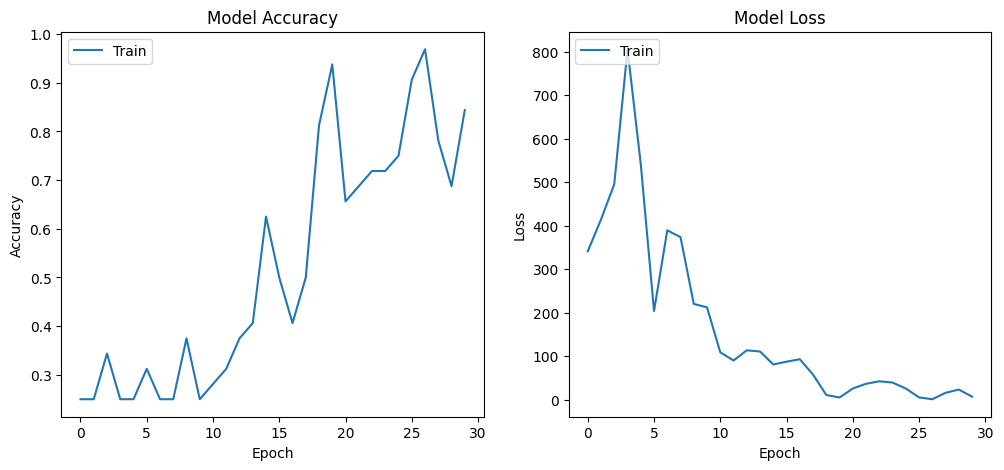

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()


In [18]:
############################################################################
# ------------------------------ Test Data ------------------------------ #
############################################################################

In [24]:
# ----- RETRIEVE TEST DATA ----- #

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)

print("## Initial shapes of the test data ##")
print(meg_test_data_array.shape)
print(labels_test_array.shape)

## Initial shapes of the test data ##
(8, 248, 35624)
(8,)


In [25]:
# ----- CALLING THE PROCESSING FUNCTION ----- #

processed_data = np.zeros((meg_test_data_array.shape[0], meg_test_data_array.shape[1], 25))
print(processed_data.shape)
for i in range(meg_test_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_test_data_array[i], i+1)

(8, 248, 25)
*** FILE 1 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 2 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 3 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 4 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 5 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data after extracting features: (248, 25)
*** FILE 6 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), downsam applied: shape: (248, 8904), Data afte

In [31]:
X_test = processed_data
y_test = to_categorical(labels_test_array, num_classes=4)

del processed_data, labels_test_array

In [32]:
print("## Data after processing ##")
print("MEG:", X_test.shape)
print("Labels:", y_test.shape)

## Data after processing ##
MEG: (8, 248, 25)
Labels: (8, 4)


In [33]:
# TEST EACH SENSOR INDEPENDENTLY

test_loss, test_accuracy = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 251ms/step - loss: 15.8168 - accuracy: 0.7500


In [38]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# Convert predictions and true labels to single labels if they are one-hot encoded
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

1/1 [==============================] - 0s 39ms/step


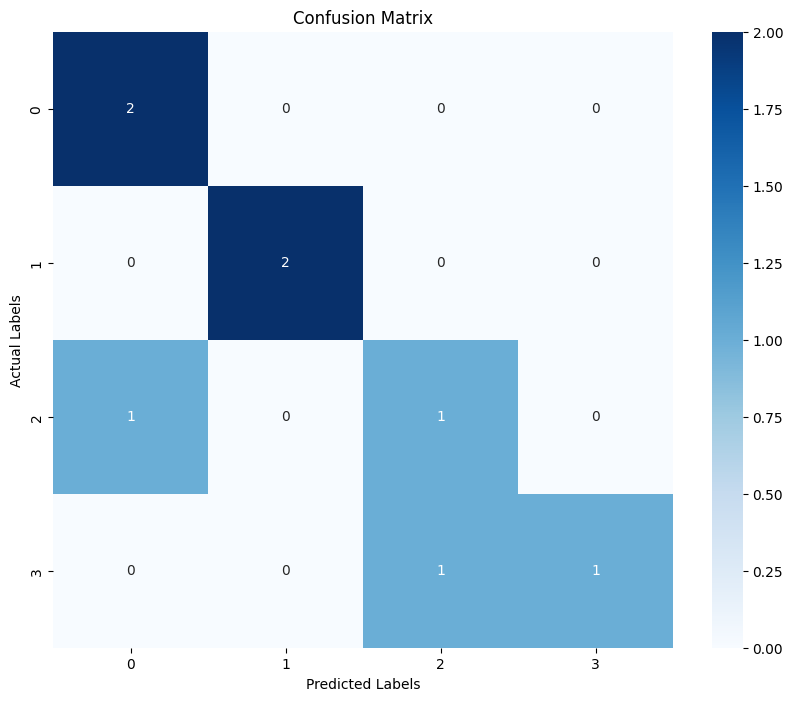

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
